# **Image Retrieval-Augmented Generation (RAG) with Llama Vision Model for Query-Based Image Retrieval**

 In this Jupyter notebook, we implement an image retrieval-augmented generation (RAG) architecture that processes a folder of images using the Llama vision model to generate image descriptions. These descriptions are then passed into the RAG framework, enabling the retrieval of relevant images based on user queries. This notebook demonstrates how AI can be used to generate context-aware descriptions of images, enhancing the efficiency of image retrieval systems.

In [1]:
!pip install langchain langchain_groq langchain_community faiss-cpu sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127

### **1: Import Libraries and Initialize Model**

This step imports the necessary libraries for handling images, interacting with the Llama vision model, and processing data. It also sets the folder path for images and initializes the Llama vision model.

In [2]:
import os
import io
import base64
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langchain.schema import Document
import pickle
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate

In [3]:
from google.colab import userdata
api_key = userdata.get('groq_api_image')

In [23]:
directory_path = "/content/drive/MyDrive/image_test"
llm_model = ChatGroq(temperature=0.5, model="llama-3.2-11b-vision-preview", api_key=api_key)


### **2: Fetch and Encode Images**

This function fetches image files from the specified directory, converts them into base64 format, and stores the encoded images along with their file paths in a list. The output displays the list of image paths that were found and successfully encoded.



In [5]:
def get_encoded_images(directory_path):
    """Fetch image file paths and convert them to base64."""
    valid_extensions = (".jpg", ".jpeg", ".png")
    encoded_images = []

    for file in os.listdir(directory_path):
        if file.lower().endswith(valid_extensions):
            path = os.path.join(directory_path, file)
            with open(path, "rb") as image_file:
                image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
                encoded_images.append({"image_path": path, "image_base64": image_base64})

    return encoded_images

encoded_images = get_encoded_images(directory_path)
print("Found and Encoded Images:", [img["image_path"] for img in encoded_images])


Found and Encoded Images: ['/content/drive/MyDrive/image_test/Copy of 20220212_162930.jpg', '/content/drive/MyDrive/image_test/Copy of IMG-20250116-WA0027.jpg', '/content/drive/MyDrive/image_test/Copy of IMG_20200927_140255.jpg', '/content/drive/MyDrive/image_test/Copy of 20230427_121016.jpg', '/content/drive/MyDrive/image_test/Copy of IMG-20250116-WA0055.jpg', '/content/drive/MyDrive/image_test/Copy of 20211019_165005 (1).jpg', '/content/drive/MyDrive/image_test/Copy of 20221228_144540.jpg', '/content/drive/MyDrive/image_test/Copy of IMG_20211230_162850.jpg', '/content/drive/MyDrive/image_test/Copy of IMG_20211229_071827.jpg', '/content/drive/MyDrive/image_test/Copy of Aadi.jpg']


### **3: Generate Structured Descriptions for Images**

This step processes the base64-encoded images by sending them to the Llama vision model with a structured prompt. The model generates a detailed description of each image, including aspects like general overview, objects, actions, environment, colors, and more. The resulting descriptions are stored as LangChain Document objects, along with the original image paths.

In [6]:
prompt_text = (
   '''
  Analyze the given base64-encoded image and generate a structured description covering the following aspects, the reponse should be stirctly in the format given:

  Output Format:

  General Overview: Provide a high-level summary of the image, describing the primary subject and scene.
  Objects & Entities: List all identifiable objects, people, animals, or elements in the image.
  Actions & Interactions: Identify any activities or interactions occurring within the scene.
  Environment & Background: Describe the setting and contextual details (e.g., indoors, outdoors, cityscape, natural scenery).
  Location: If the location is identifiable based on surroundings (e.g., landmarks, signage, geographic features), mention it. If it cannot be determined, explicitly state that the location is unknown. Do not assume or infer.
  Colors & Lighting: Describe the dominant colors, contrast levels, and lighting conditions (e.g., bright, dim, natural, artificial).
  Composition & Perspective: Explain the framing, camera angle, depth of field, and focal points.
  Emotions & Expressions: If people are present, describe their facial expressions, emotions, and possible intent.
  Possible Context & Meaning: Infer the possible context, intent, or message conveyed by the image.


  Return the response in a structured format, where each aspect is clearly labeled as shown above.
  Keep the descriptions detailed and precise, don't be overly verbose.
  Keep it in less than 200 words strictly while covering all the asppects in given format.
   '''
)

contextualized_images = []

for img in encoded_images:
    msg = model.invoke([
        HumanMessage(
            content=[
                {"type": "text", "text": prompt_text},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img['image_base64']}"}}
            ]
        )
    ])

    # Create a LangChain Document object
    contextualized_content = msg.content
    contextualized_images.append(Document(page_content=contextualized_content, metadata={"image_path": img["image_path"]}))


In [7]:
for doc in contextualized_images:
    print(f"Image: {doc.metadata['image_path']}\nDescription: {doc.page_content}\n")

Image: /content/drive/MyDrive/image_test/Copy of 20220212_162930.jpg
Description: The image depicts a group of seven individuals sitting on a stone wall, with a cityscape and mountains in the background.

**Objects & Entities:**

* Seven people sitting on a stone wall
* A stone wall
* A cityscape in the background
* Mountains in the background

**Actions & Interactions:**

* The group of people are sitting on the stone wall, possibly posing for a photo or enjoying a scenic view.

**Environment & Background:**

* The scene is set outdoors, with a clear blue sky and a cityscape in the distance.
* The cityscape features many buildings and structures.
* Mountains are visible in the background, adding depth to the scene.

**Location:**

* The location is unknown, but it appears to be a rural or mountainous area.

**Colors & Lighting:**

* The dominant colors are shades of brown, gray, and blue.
* The lighting is natural, with the sun shining down on the scene.

**Composition & Perspective:*

### **4: Initialize Embedding Model and FAISS Index**

In this step, the HuggingFaceEmbeddings model is initialized using a pre-trained embedding model (all-MiniLM-L6-v2). It also ensures that the FAISS index directory exists, preparing the system for storing and querying vector embeddings.

In [8]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
faiss_path = "faiss_index"

# Initialize embedding model
embeddings = HuggingFaceEmbeddings(model_name=embedding_model)

# Ensure FAISS directory exists
if not os.path.exists(faiss_path):
    os.makedirs(faiss_path)

<ipython-input-8-b72d1a063b55>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### **5: Split Documents and Generate Embeddings**

This step splits the contextualized image descriptions into smaller chunks for better embedding efficiency. It then generates embeddings for these chunks and stores them in a FAISS index for efficient similarity search. The FAISS index is saved locally for future use.

In [9]:
def split_documents(documents):
    """
    Splits documents into smaller chunks for better embedding efficiency.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1024,
        chunk_overlap=100,
        length_function=len,
        add_start_index=True
    )
    return text_splitter.split_documents(documents)

def generate_embeddings(contextualized_documents):
    """
    Processes contextualized image descriptions, splits them, and stores embeddings in FAISS.
    """
    # Step 1: Split documents into chunks
    chunks = split_documents(contextualized_documents)
    print(f"Split {len(contextualized_documents)} documents into {len(chunks)} chunks.")

    # Step 2: Store embeddings in FAISS
    db = FAISS.from_documents(chunks, embeddings)

    # Save FAISS index
    db.save_local(faiss_path)
    print(f"Saved {len(chunks)} chunks to {faiss_path}.")

    return db  # Returning the FAISS database instance for retrieval if needed

In [10]:
faiss_db = generate_embeddings(contextualized_images)

Split 10 documents into 22 chunks.
Saved 22 chunks to faiss_index.


In [15]:
faiss_path = "/content/faiss_index"
model_name = "llama-3.2-11b-vision-preview"
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"

### **6: Retrieve Relevant Images Based on Query**

This step defines a function to retrieve the most relevant images based on a query text. It loads the FAISS index, performs a similarity search to find the closest matching descriptions, and formats the results into a structured JSON response containing the image paths. The function also ensures that the query results are returned in a clean format without any extraneous explanations.

In [26]:
def retrieve_images(query_text, faiss_path="/content/faiss_index", llm_model="llama-3.2-11b-vision-preview", embedding_model="sentence-transformers/all-MiniLM-L6-v2", k=5):

    # Step 1: Check if FAISS index exists
    if not os.path.exists(faiss_path):
        raise ValueError(f"FAISS index path '{faiss_path}' does not exist. Run embedding generation first.")

    # Step 2: Load the FAISS index and embeddings model
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
    db = FAISS.load_local(faiss_path, embeddings, allow_dangerous_deserialization=True)

    # Step 3: Perform similarity search
    results = db.similarity_search_with_relevance_scores(query_text, k=k)

    # Extract image paths from results
    image_paths = [doc.metadata.get("image_path", "") for doc, _ in results]

    PROMPT_TEMPLATE = """
                          Retrieve the most relevant images based on the given context.

                          Image Paths:
                          {image_list}

                          Context:
                          {context}

                          ---

                          Based on the above context, provide the most relevant image paths for the following query:
                          Query: {question}

                          Return only a valid JSON object with the following format:

                          {{
                              "image_paths": ["path1", "path2", "path3", ...]
                          }}

                          Strictly avoid adding explanations or extra text. Do not create any image paths on your own. Ensure that the JSON contains only the number of image paths available, up to a maximum of similar images.
                      """

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _ in results])
    image_list = ",\n        ".join(f'"{path}"' for path in image_paths)

    # Format the prompt
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text, image_list=image_list)

    llm_model = ChatGroq(temperature=0.5, model="llama-3.2-11b-vision-preview", api_key=api_key)

    response_text = llm_model.predict(prompt)
    response_data = json.loads(response_text)

    return response_data


### **7: Display Retrieved Image**

This step defines a function to display the first retrieved image based on the query result. It checks if there are image paths in the response data and then uses matplotlib to load and display the first image from the list of retrieved paths.

In [17]:
def open_first_image(response_data):

    # Ensure there are image paths in the response
    if "image_paths" in response_data and response_data["image_paths"]:
        first_image_path = response_data["image_paths"][0]
        print(f"Displaying first retrieved image: {first_image_path}")
        # Read and display the image
        img = mpimg.imread(first_image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("No image paths found in the response.")

Displaying first retrieved image: /content/drive/MyDrive/image_test/Copy of IMG_20211230_162850.jpg


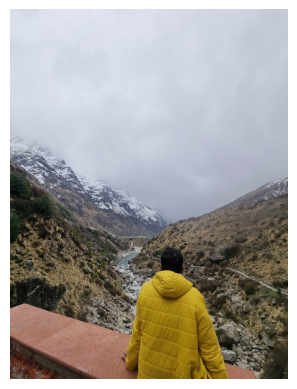

In [31]:
response = retrieve_images("Get my image wearing something yellow in mountains")
open_first_image(response)
